In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [2]:

data_dir = 'data'
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


949


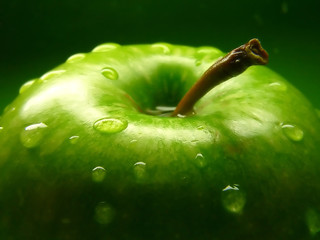

In [3]:
apple = list(data_dir.glob('apple/*'))
Image.open(str(apple[0]))


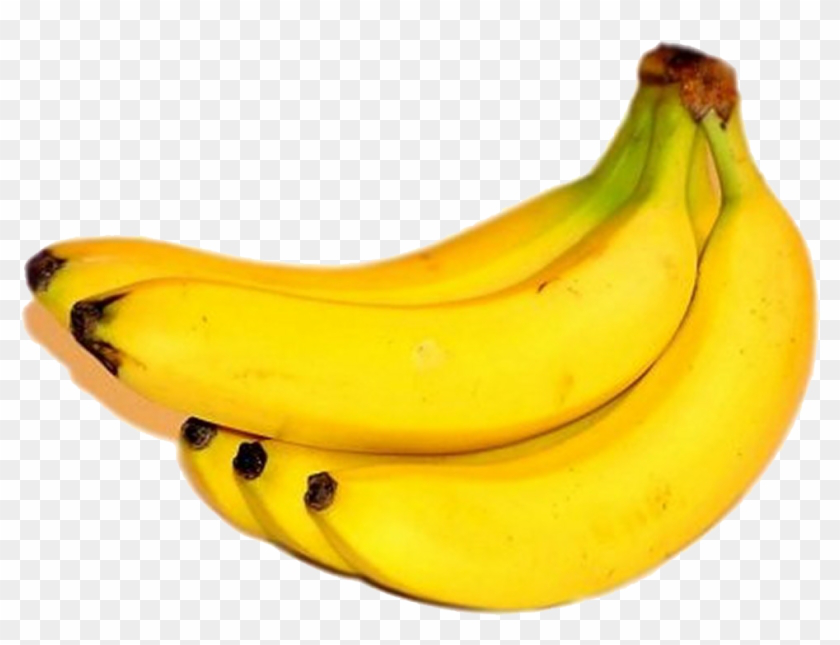

In [4]:
banana = list(data_dir.glob('banana/*'))
Image.open(str(banana[1]))


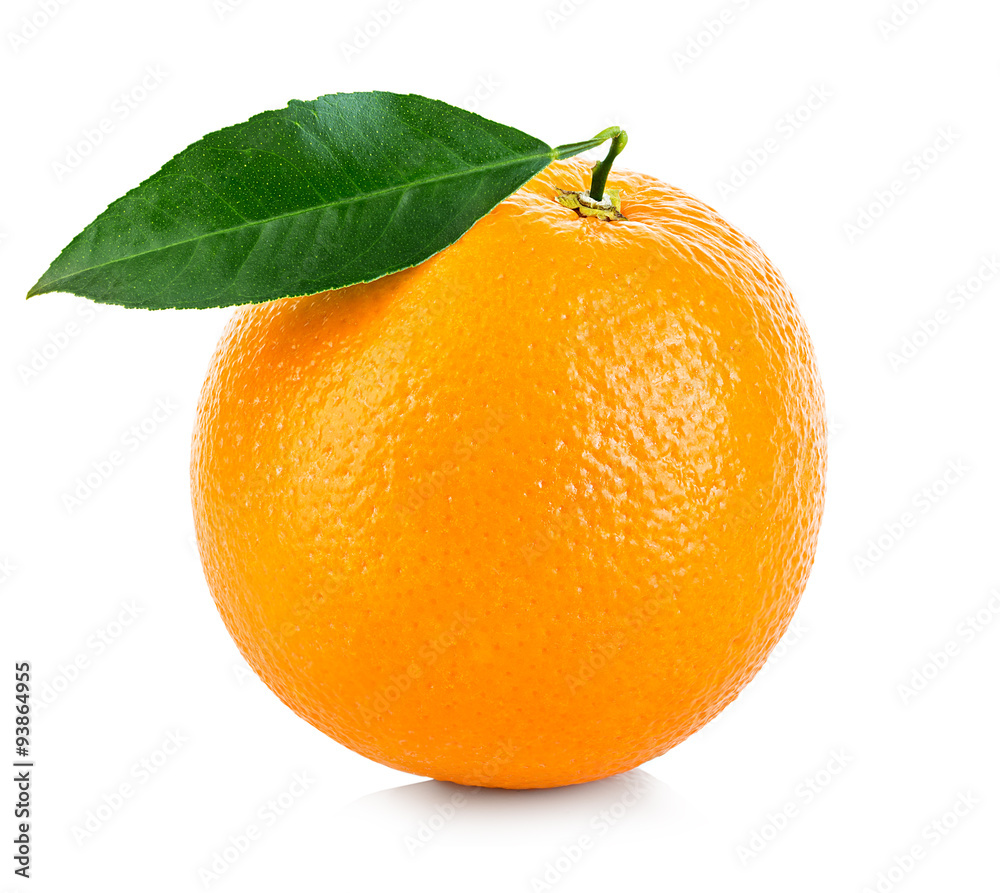

In [5]:
orange = list(data_dir.glob('orange/*'))
Image.open(str(orange[0]))


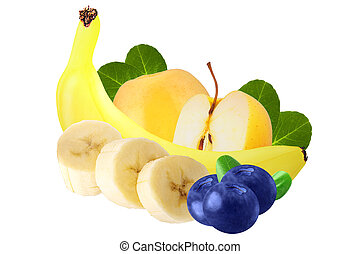

In [6]:
mixed = list(data_dir.glob('mixed/*'))
Image.open(str(mixed[0]))


In [7]:
import cv2
import imghdr


In [8]:
batch_size = 68
img_height = 190
img_width = 190


In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 1725 files belonging to 4 classes.
Using 1380 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 1725 files belonging to 4 classes.
Using 345 files for validation.


In [11]:
data_dir = 'data'
image_exts = ['jpg', 'jpeg', 'png', 'bmp']


In [12]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        print(image)


240_F_103901_TFOCnobYr9oFY0I6PLI5tBcQsAcui1.jpg
240_F_105813067_d3ebgmbPMd3HgDuQp3ifhpCw5mtKaAh3.jpg
240_F_107243962_93O8mMEWlLU1mGgEdwS0dIv37fbLWfaV.jpg
240_F_111105580_L5bFay5SQ6Zjd0BxWLRcccobrjL6evyq.jpg
240_F_126476396_qr1sjNeynZc24Qi4cq4ehQU3nGHy1P7i.jpg
240_F_126670783_XNNcDwYsag1iDPcBHwt3mwfUsIXWzycM.jpg
240_F_126978019_uBzbqYxtFLsmWvbZpVFZ4w6cnZVPSTHD.jpg
240_F_127331658_Xppa11HO5Y3M3Z7oBjYzimXxL5X5B5yZ.jpg
240_F_129214387_TmzXkJZZdi9MpQ5WHxpmp5GhsrWyUlLn.jpg
240_F_130378636_m8XUpOkBqxVBnY8bAZvu3uDpzgWWRUc4.jpg
240_F_1629649_CxgYa6Kii6piaxLqEkl8skcVWBhvJp.jpg
240_F_178792002_k2RhpAEQ7GDjfAia4eb3bPKEr0gcXNQ8.jpg
240_F_178919820_P2pZcZaRlmdnPyzySimiwUO8gxUdXczm.jpg
240_F_182427339_IQ7A0ceEqKN1FLif6WZrjpF79lSe3FLC.jpg
240_F_187973752_aFbzGjWD91HUJhCD8lTwBWN9zYCyAPFb.jpg
240_F_194451468_QwTp4EX7p2tYon9U80qZYKlQFjk08vhP.jpg
240_F_202670033_L2na30dIVjD5o2UlvF9DT0wlzdFIti04.jpg
240_F_20883889_iKkxtRLC0zTI9kFVNiFbrR0G2sc4CrTk.jpg
240_F_210597040_wxyvT8wGl322pfG6xO4LGW4FCWTgkOyX.jpg
240

In [13]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with Image {}'.format(image_path))


In [14]:
class_names = train_ds.class_names
print(class_names)  # apple, banana, mixed, orange


['apple', 'banana', 'mixed', 'orange']


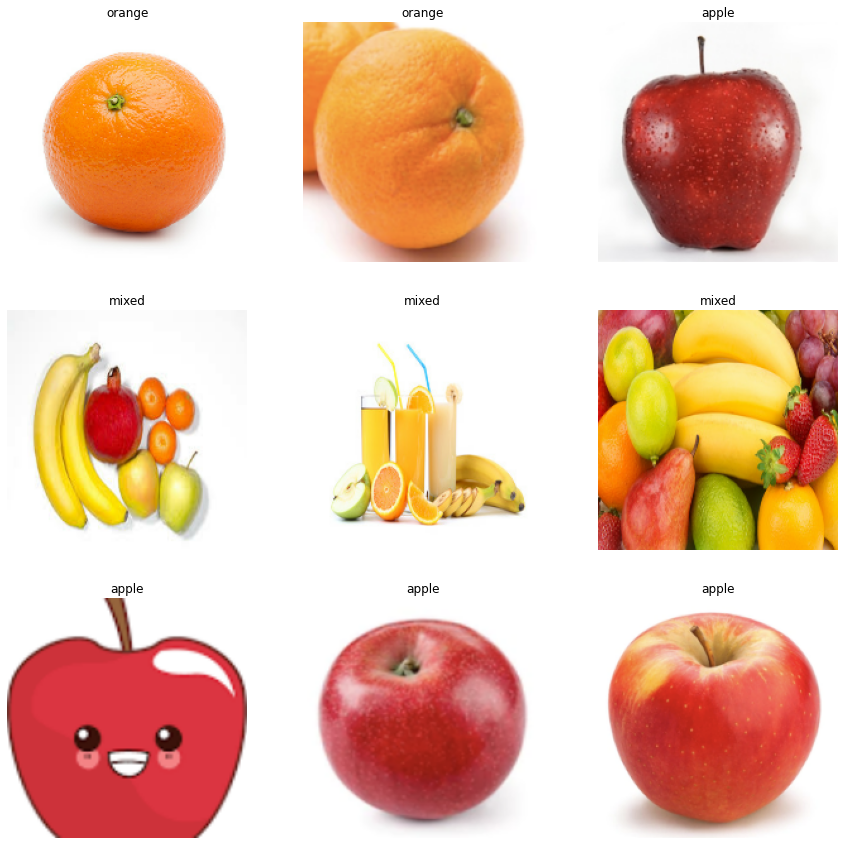

In [15]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [16]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break


(68, 190, 190, 3)
(68,)


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [18]:
train_ds


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 190, 190, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [19]:
normalization_layer = layers.Rescaling(1./255)


In [20]:
normalization_layer


In [21]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.00912634 1.0


In [22]:
num_classes = len(class_names)
num_classes


4

In [23]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])


In [24]:
num_classes


4

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])


In [26]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 190, 190, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 190, 190, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 95, 95, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 95, 95, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 47, 47, 64)        1

In [27]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/10
21/21 [==============================] - 13s 573ms/step - loss: 1.9219 - accuracy: 0.4413 - val_loss: 1.1147 - val_accuracy: 0.5362
Epoch 2/10
21/21 [==============================] - 11s 540ms/step - loss: 0.7838 - accuracy: 0.6848 - val_loss: 0.6921 - val_accuracy: 0.7391
Epoch 3/10
21/21 [==============================] - 11s 543ms/step - loss: 0.4910 - accuracy: 0.8167 - val_loss: 0.4553 - val_accuracy: 0.8638
Epoch 4/10
21/21 [==============================] - 12s 574ms/step - loss: 0.3408 - accuracy: 0.8826 - val_loss: 0.3748 - val_accuracy: 0.8696
Epoch 5/10
21/21 [==============================] - 12s 572ms/step - loss: 0.2389 - accuracy: 0.9261 - val_loss: 0.3445 - val_accuracy: 0.9014
Epoch 6/10
21/21 [==============================] - 12s 571ms/step - loss: 0.1915 - accuracy: 0.9428 - val_loss: 0.3488 - val_accuracy: 0.9043
Epoch 7/10
21/21 [==============================] - 12s 592ms/step - loss: 0.1445 - accuracy: 0.9587 - val_loss: 0.3895 - val_accuracy: 0.9014

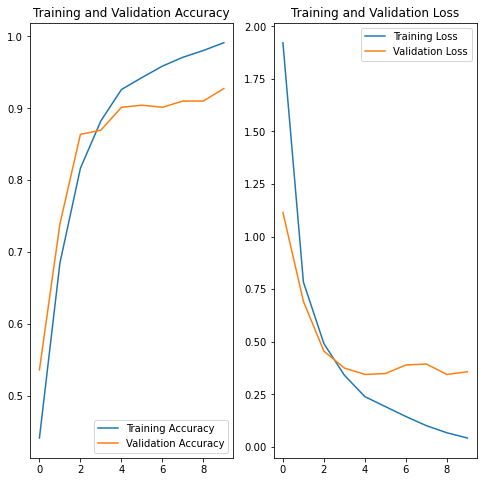

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [29]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                       img_width,
                                       3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)


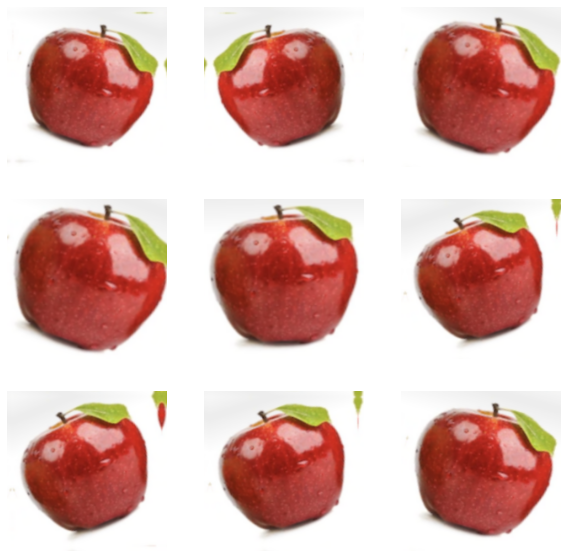

In [30]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [31]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),   
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes ,name="outputs")
])


In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])


In [33]:
epochs = 18
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    
)


Epoch 1/18
21/21 [==============================] - 15s 561ms/step - loss: 1.3597 - accuracy: 0.3435 - val_loss: 1.2263 - val_accuracy: 0.4754
Epoch 2/18
21/21 [==============================] - 12s 570ms/step - loss: 1.0025 - accuracy: 0.6007 - val_loss: 0.7408 - val_accuracy: 0.7159
Epoch 3/18
21/21 [==============================] - 12s 591ms/step - loss: 0.6815 - accuracy: 0.7348 - val_loss: 0.4844 - val_accuracy: 0.8087
Epoch 4/18
21/21 [==============================] - 12s 584ms/step - loss: 0.5161 - accuracy: 0.8217 - val_loss: 0.4548 - val_accuracy: 0.8348
Epoch 5/18
21/21 [==============================] - 12s 587ms/step - loss: 0.4224 - accuracy: 0.8522 - val_loss: 0.3756 - val_accuracy: 0.8870
Epoch 6/18
21/21 [==============================] - 12s 592ms/step - loss: 0.3801 - accuracy: 0.8703 - val_loss: 0.4638 - val_accuracy: 0.8551
Epoch 7/18
21/21 [==============================] - 13s 618ms/step - loss: 0.4028 - accuracy: 0.8674 - val_loss: 0.3948 - val_accuracy: 0.8580

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 190, 190, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 190, 190, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 190, 190, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 95, 95, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 95, 95, 16)        2320      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 47, 47, 16)       0         
 2D)                                                  

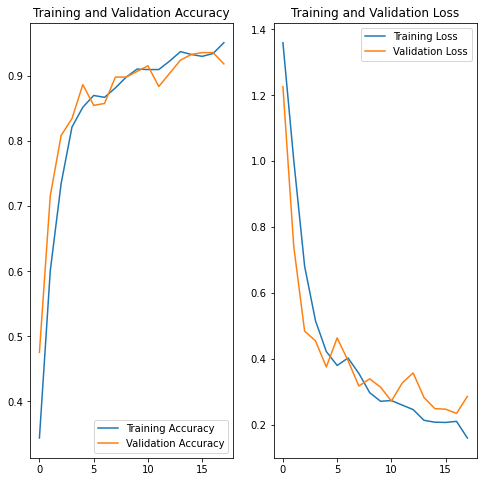

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [36]:
import cv2


In [37]:
test_dir = 'test'

In [38]:
for image_class in os.listdir(test_dir):
    print(image_class)

apple_77.jpg
apple_78.jpg
apple_79.jpg
apple_80.jpg
apple_81.jpg
apple_82.jpg
apple_83.jpg
apple_84.jpg
apple_85.jpg
apple_86.jpg
apple_87.jpg
apple_88.jpg
apple_89.jpg
apple_90.jpg
apple_91.jpg
apple_92.jpg
apple_93.jpg
apple_94.jpg
apple_95.jpg
banana_77.jpg
banana_78.jpg
banana_79.jpg
banana_80.jpg
banana_81.jpg
banana_82.jpg
banana_83.jpg
banana_84.jpg
banana_85.jpg
banana_86.jpg
banana_87.jpg
banana_88.jpg
banana_89.jpg
banana_90.jpg
banana_91.jpg
banana_92.jpg
banana_93.jpg
banana_94.jpg
mixed_21.jpg
mixed_22.jpg
mixed_23.jpg
mixed_24.jpg
mixed_25.jpg
orange_77.jpg
orange_78.jpg
orange_79.jpg
orange_80.jpg
orange_81.jpg
orange_82.jpg
orange_83.jpg
orange_84.jpg
orange_85.jpg
orange_86.jpg
orange_87.jpg
orange_89.jpg
orange_90.jpg
orange_91.jpg
orange_92.jpg
orange_93.jpg
orange_94.jpg
orange_95.jpg


In [39]:
for image_class in os.listdir(test_dir):
        img = cv2.imread(image_class)
        


In [74]:
apple_corr = 0
banana_corr = 0
orange_corr = 0
mixed_corr = 0

for filename in os.listdir(test_dir):
        img = cv2.imread(os.path.join("test", filename))
        # img_data = np.array(img)
        resize = tf.image.resize(img, (img_width, img_height))
        resize = resize.numpy().astype('uint8')
        img_array = tf.keras.utils.img_to_array(resize)
        img_array = tf.expand_dims(img_array, 0)
        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        print(score)
        print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
        )
        if class_names[np.argmax(score)] in filename:
                if class_names[np.argmax(score)] == 'apple':
                        apple_corr += 1
                elif class_names[np.argmax(score)] == 'banana':
                        banana_corr += 1
                elif class_names[np.argmax(score)] == 'orange':
                        orange_corr += 1
                elif class_names[np.argmax(score)] == 'mixed':
                        mixed_corr += 1

        

        

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [41]:
print("Apple Correct: " + str(apple_corr))
print("Banana Correct: " + str(banana_corr))
print("Orange Correct: " + str(orange_corr))
print("Mixed Correct: " + str(mixed_corr))

Apple Correct: 18
Banana Correct: 15
Orange Correct: 10
Mixed Correct: 3


In [42]:
Accuracy = (apple_corr + banana_corr + orange_corr + mixed_corr)/60
Accuracy

0.7666666666666667

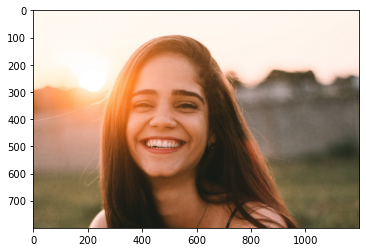

In [56]:
img = cv2.imread('test/mixed_23.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()


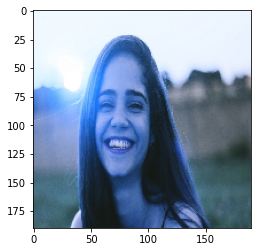

In [57]:

resize = tf.image.resize(img, (img_width, img_height))
resize = resize.numpy().astype('uint8')
plt.imshow(resize)
# plt.imshow(cv2.cvtColor(resize.numpy().astype(int), cv2.COLOR_BGR2RGB))
plt.show()


In [58]:
img_array = tf.keras.utils.img_to_array(resize)
img_array = tf.expand_dims(img_array, 0)


In [59]:
resize.shape


(190, 190, 3)

In [60]:
img_array.shape


TensorShape([1, 190, 190, 3])

In [61]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])


1/1 [==============================] - 0s 21ms/step


In [62]:
score


<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.6712915 , 0.08285719, 0.13780385, 0.10804743], dtype=float32)>

In [63]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to apple with a 67.13 percent confidence.


In [64]:
class_names


['apple', 'banana', 'mixed', 'orange']

In [65]:
test_dir = 'train'

In [66]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 240 files belonging to 4 classes.


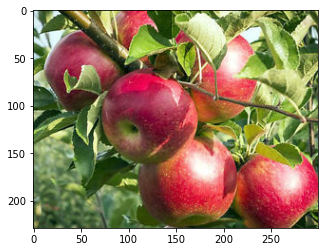

In [67]:
img = Image.open('test/apple_77.jpg')
img_data = np.array(img)
plt.imshow(img_data)


In [69]:
ch_test_dir = 'CH_test'
test_ds = tf.keras.utils.image_dataset_from_directory(
    ch_test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 60 files belonging to 4 classes.


In [71]:
evaluation = model.evaluate(test_ds )

1/1 [==============================] - 0s 287ms/step - loss: 0.1915 - accuracy: 0.9500


In [1]:
prediction = model.predict(test_ds)

NameError: name 'model' is not defined